# Double Jet

With various grid sizes

In [1]:
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.style.use('dark_background')

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.DoubleJetPlot import *

Get initial arguments from class

In [4]:
from gpuocean.utils import DoubleJetCase

In [5]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

## Truth

In [6]:
truth_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetTruth/2023-10-30T13_00_13"

true_state = np.load(os.path.join(truth_path, "truth_864000.npy"))

(<Figure size 1500x1000 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

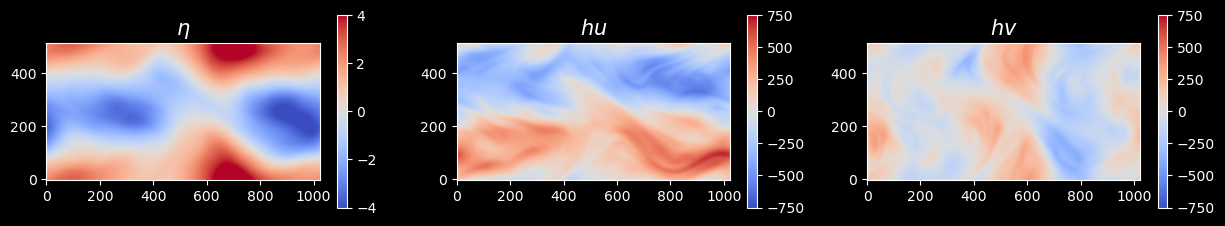

In [7]:
imshow3(true_state, eta_vlim=4)

## Ensembles

In [8]:
from utils.DoubleJetSL import *

In [9]:
def plot_SLstates(sl_state):
    from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
    from mpl_toolkits.axes_grid1.colorbar import colorbar

    fig, axs = plt.subplots(3,3, figsize=(20,15))

    def _add_cb(ax, im, label=None):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(label)


    SL_mean = np.mean(sl_state, axis=-1)
    vlims = [4, 750, 750]
    for i in range(3):
        im = axs[0,i].imshow(SL_mean[i], cmap=plt.cm.coolwarm, vmin=-vlims[i], vmax=vlims[i])
        _add_cb(axs[0,i], im)

    SL_std = np.std(sl_state, axis=-1, ddof=1)
    vlims = [0.5, 100, 100]
    for i in range(3):
        im = axs[1,i].imshow(SL_std[i], cmap=plt.cm.Oranges, vmin=0, vmax=vlims[i])
        _add_cb(axs[1,i], im)

    rescale = true_state.shape[1]//sl_state.shape[1]
    SL_err = np.abs(np.mean(sl_state, axis=-1).repeat(rescale,1).repeat(rescale,2) - true_state) 
    vlims = [0.5, 100, 100]
    for i in range(3):
        im = axs[2,i].imshow(SL_err[i], cmap=plt.cm.Reds, vmin=0, vmax=vlims[i])
        _add_cb(axs[2,i], im)

In [10]:
slda1_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetSLDA/2023-11-05T19_12_27"

sl1_state = np.load(os.path.join(slda1_path, "SLstates/SLensemble_864000.npy"))

In [11]:
slda2_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetSLDA/2023-11-05T19_13_08"

sl2_state = np.load(os.path.join(slda2_path, "SLstates/SLensemble_864000.npy"))

In [12]:
slda3_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetSLDA/2023-11-05T19_12_53"

sl3_state = np.load(os.path.join(slda3_path, "SLstates/SLensemble_864000.npy"))

/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  


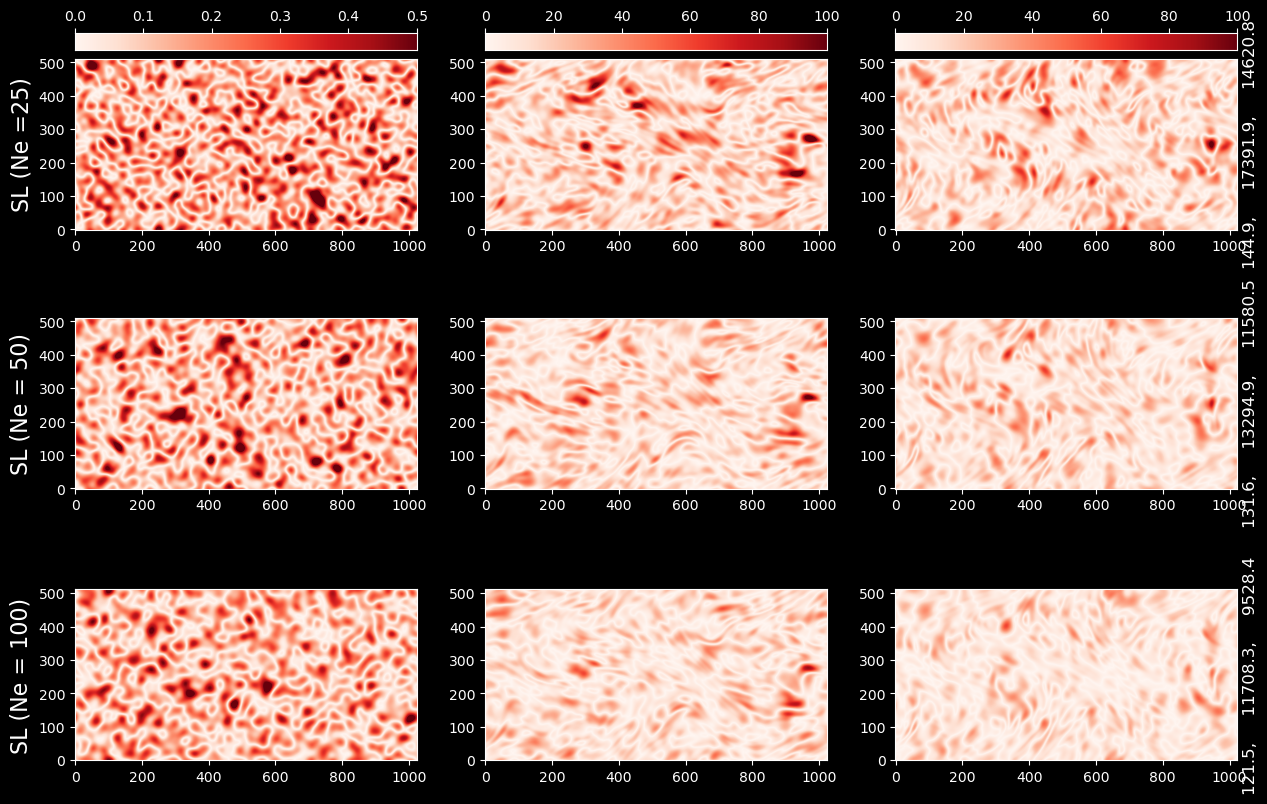

In [13]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

fig, axs = plt.subplots(3,3, figsize=(15,10))

def _add_cb(ax, im, label=None):
    ax_divider = make_axes_locatable(ax)
    ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
    cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
    ax_cb.xaxis.set_ticks_position("top")
    ax_cb.set_title(label)

vlims=[0.5, 100, 100]
def _plot3(axs, state, cbar=False):
    for i in range(3):
        im = axs[i].imshow(state[i], cmap=plt.cm.Reds, vmin=0, vmax=vlims[i])
        if cbar:
            _add_cb(axs[i], im)
    axs[2].yaxis.set_label_position("right")
    axs[2].set_ylabel(",     ".join(["{:.1f}".format(v) for v in np.linalg.norm(state, axis=(1,2))]), fontsize=12)


axs[0,0].set_ylabel("SL (Ne =25)", fontsize=16)
SL_err = np.abs(np.mean(sl1_state, axis=-1) - true_state)
_plot3(axs[0], SL_err, cbar=True) 

axs[1,0].set_ylabel("SL (Ne = 50)", fontsize=16)
SL2_err = np.abs(np.mean(sl2_state, axis=-1) - true_state)
_plot3(axs[1], SL2_err) 

axs[2,0].set_ylabel("SL (Ne = 100)", fontsize=16)
SL3_err = np.abs(np.mean(sl3_state, axis=-1) - true_state)
_plot3(axs[2], SL3_err) 


In [14]:
Ts = np.arange(0, 13*24*3600, 900)/(24*3600)

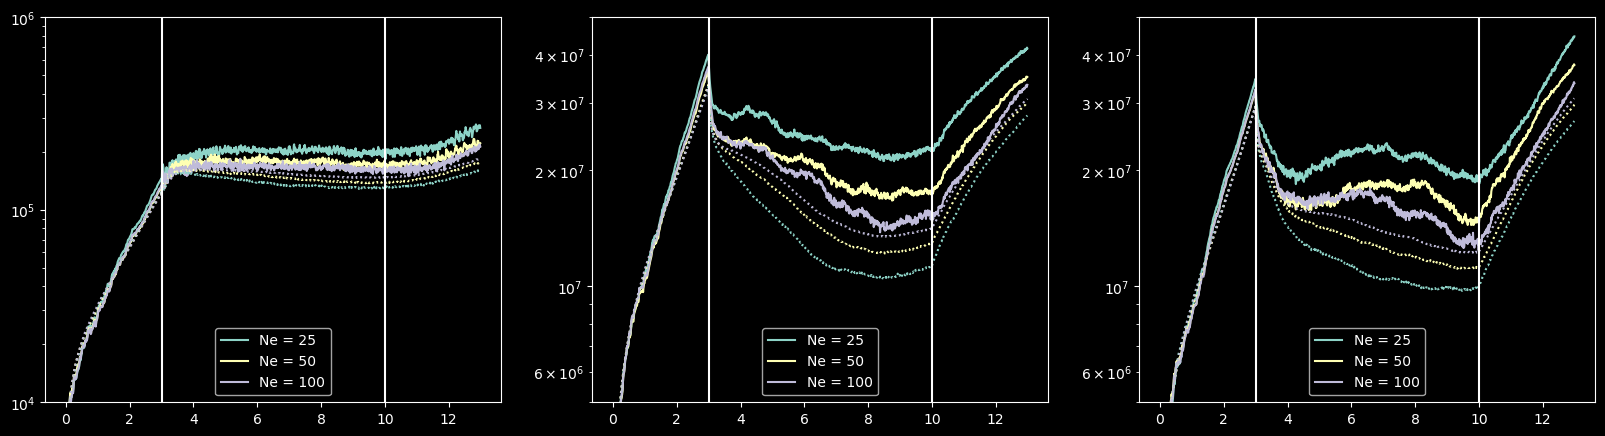

In [15]:
fig, axs = plt.subplots(1,3, figsize=(20,5))

sl1_rmse = np.load(slda1_path + "/rmse.npy")
sl2_rmse = np.load(slda2_path + "/rmse.npy")
sl3_rmse = np.load(slda3_path + "/rmse.npy")

sl1_std = np.load(slda1_path + "/stddev.npy")
sl2_std = np.load(slda2_path + "/stddev.npy")
sl3_std = np.load(slda3_path + "/stddev.npy")

for i in range(3):
    axs[i].set_yscale("log")
    axs[i].plot(Ts, sl1_rmse[:,i], c="C0", label="Ne = 25")
    axs[i].plot(Ts, sl2_rmse[:,i], c="C1", label="Ne = 50")
    axs[i].plot(Ts, sl3_rmse[:,i], c="C2", label="Ne = 100")

    axs[i].plot(Ts, sl1_std[:,i], c="C0", ls="dotted")
    axs[i].plot(Ts, sl2_std[:,i], c="C1", ls="dotted")
    axs[i].plot(Ts, sl3_std[:,i], c="C2", ls="dotted")
    
    axs[i].axvline(3, c="white")
    axs[i].axvline(10, c="white")
    axs[i].legend()

    if i == 0:
        axs[i].set_ylim((1e4, 1e6))
    else:
        axs[i].set_ylim((5e6, 5e7))

# for i in range(1,3):
#     axs[i].axhline(np.sqrt(np.sum(500*np.ones((doubleJetCase_args["nx"],doubleJetCase_args["ny"]))*doubleJetCase_args["dx"]*doubleJetCase_args["dy"])), c="white")


In [26]:
np.amax(sl2_rmse[600:,2]/sl3_rmse[600:,2])

1.24378

In [27]:
np.mean(sl2_rmse[600:,2]/sl3_rmse[600:,2])

1.1571348